In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

try:
  import flax
except ModuleNotFoundError:
  !pip install --quiet flax
  import flax

try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

try:
  import diffrax
except ModuleNotFoundError:
  !pip install --quiet diffrax
  import diffrax

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial

/ssd003/home/kirill/venvs/jax-env/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [3]:
from typing import NamedTuple, Any

class TimedX(NamedTuple):
  t: Any
  x: jnp.ndarray

def gaussians(jseed, t):
  jseeds = random.split(jseed, 3)
  x_1 = random.randint(jseeds[0], minval=0, maxval=2, shape=(t.shape[0], 2))
  x_1 = x_1.astype(float)-0.5
  x_1 += 1e-1*random.normal(jseeds[1], shape=(t.shape[0],2))
  x_0 = 1e-1*random.normal(jseeds[2], shape=(t.shape[0],2))
  x_t = jnp.sqrt(1-t)*x_0 + jnp.sqrt(t)*x_1
  return x_0, x_1, x_t

def diamonds(jseed, t):
  jseeds = random.split(jseed, 4)
  x_1 = random.randint(jseeds[0], minval=0, maxval=2, shape=(t.shape[0], 2))
  x_1 = x_1.astype(float)-0.5
  x_1 = x_1.at[:,0].set(0.5)

  x_0 = random.randint(jseeds[1], minval=0, maxval=2, shape=(t.shape[0], 2))
  x_0 = x_0.astype(float)-0.5
  x_0 = x_0.at[:,0].set(-0.5)

  R = jnp.array([[1/math.sqrt(2),-1/math.sqrt(2)],
                 [1/math.sqrt(2),1/math.sqrt(2)]])
  x_1 += 5e-1*(random.uniform(jseeds[2], shape=(t.shape[0],2))-0.5)@R
  x_0 += 5e-1*(random.uniform(jseeds[3], shape=(t.shape[0],2))-0.5)@R
  x_t = (1-t)*x_0 + t*x_1
  
  return x_0, x_1, x_t

# DEFINE THE DYNAMICS TO USE HERE
q_t = diamonds

In [4]:
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
DS = 2048
key, loc_key = random.split(key)
DATA_0, DATA_1, _ = q_t(loc_key, jnp.ones([DS,1]))

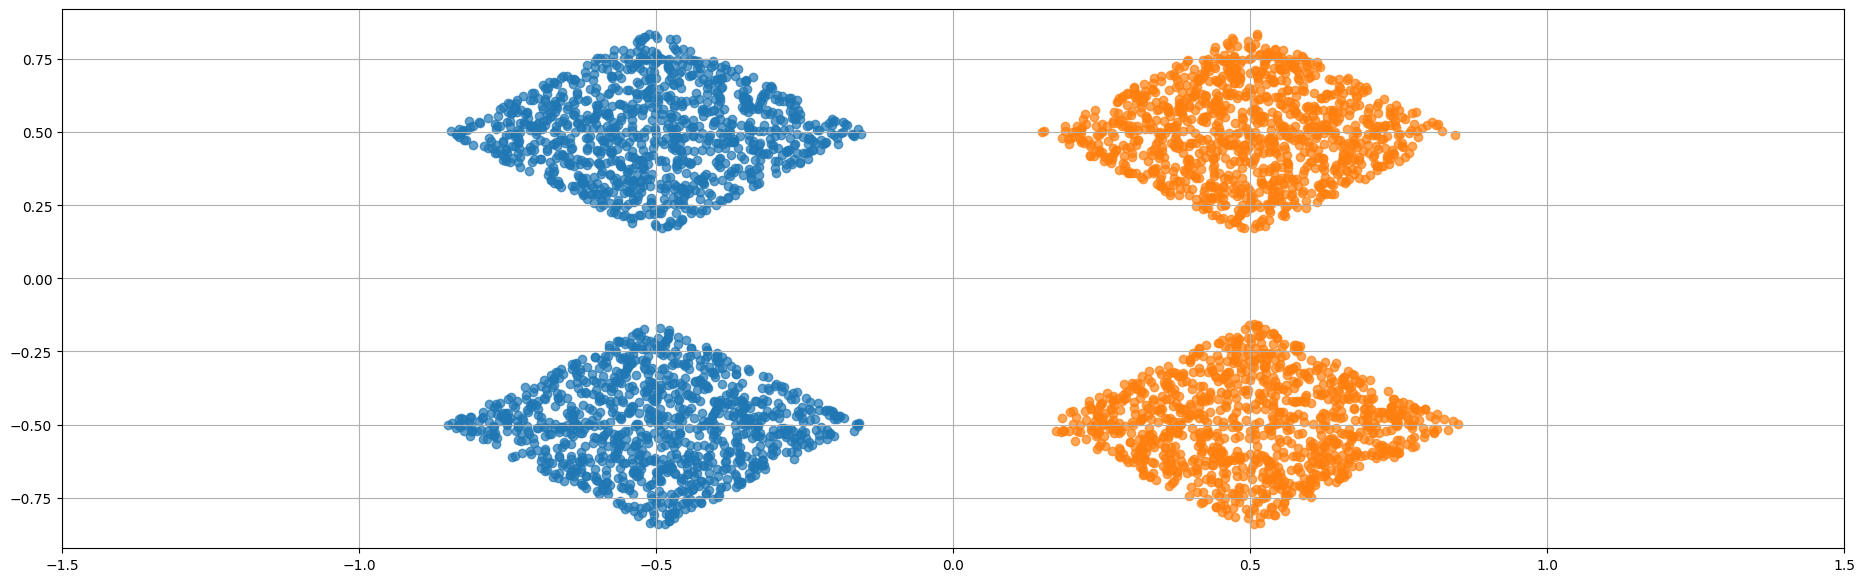

In [5]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(DATA_1[:,0], DATA_1[:,1], alpha=0.7)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()

In [6]:
class Smodel(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, t, x):
    h = jnp.hstack([t,x])
    h = nn.Dense(self.num_hid)(h)
    h = nn.relu(h)
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(self.num_out)(h)
    return h

class Qmodel(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, t, x_0, x_1, u):
    h = jnp.hstack([t, x_0, x_1, t < 0.5, u])
    # h = jnp.hstack([t, x_0, x_1]) jnp.linspace(0.0, 1.0, 10).reshape((1,-1))
    h = nn.Dense(self.num_hid)(h)
    h = nn.relu(h)
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(self.num_out)(h)
    out = (1-t)*x_0 + t*x_1 + jnp.sqrt(2*t*(1-t))*h
    return out

In [7]:
def sample_t(u0, n, t0=0.0, t1=1.0):
  u = (u0 + math.sqrt(2)*jnp.arange(n + 1)) % 1
  u = u.reshape([-1,1])
  return u[:-1]*(t1-t0) + t0, u[-1]

In [17]:
s = Smodel(num_hid=512, num_out=1)
q = Qmodel(num_hid=128, num_out=2)

BS = 512

key, *init_keys = random.split(key, 3)
state_s = train_state.TrainState.create(apply_fn=s.apply,
                                        params=s.init(init_keys[0], np.ones([BS,1]), DATA_0[:BS]),
                                        tx=optax.adam(learning_rate=2e-4))

state_q = train_state.TrainState.create(apply_fn=q.apply,
                                        params=q.init(init_keys[1], np.ones([BS,1]), DATA_0[:BS], DATA_1[:BS], np.ones([BS,10])),
                                        tx=optax.adam(learning_rate=2e-4))

# derivatives of the model that we need to define the loss
def V(t, x, p):
  dsdtdx_fn = jax.grad(lambda t, x, p: state_s.apply_fn(p,t,x).sum(), argnums=[0,1])
  dsdt, dsdx = dsdtdx_fn(t, x, p)
  return dsdt + 0.5*(dsdx**2).sum(1, keepdims=True)
dVdx_fn = jax.grad(lambda t, x, p: V(t,x,p).sum(), argnums=1)
# and to apply the model
dsdx_fn = jax.jit(jax.grad(lambda t, x, p: state_s.apply_fn(p,t,x).sum(), argnums=1))

In [18]:
def loss_fn(state_s, state_q, params_s, params_q, u0, key):
  keys = random.split(key, 3)
  t_0, t_1 = jnp.zeros([BS, 1]), jnp.ones([BS, 1])
  t, u0 = sample_t(u0, BS)
  x_0, x_1 = random.choice(keys[0], DATA_0, (BS,)), random.choice(keys[1], DATA_1, (BS,))
  u = random.uniform(keys[2], shape=(BS,10))
  x_t = state_q.apply_fn(params_q, t, x_0, x_1, u)
  update = jax.lax.stop_gradient(dVdx_fn(t, x_t, params_s))
  x_t += 1e-1*t*(1-t)*update
  x_t = jax.lax.stop_gradient(x_t)

  loss = state_s.apply_fn(params_s, t_0, x_0) - state_s.apply_fn(params_s, t_1, x_1)
  loss += V(t, x_t, params_s)
  loss -= V(t, state_q.apply_fn(params_q, t, x_0, x_1, u), jax.lax.stop_gradient(params_s))
  return loss.mean(), (jnp.sqrt((update**2).sum(1)).mean(), u0)

@jax.jit
def train_step(state_s, state_q, u0, key):
  grad_fn = jax.value_and_grad(loss_fn, argnums=[2,3], has_aux=True)
  (loss, (gradV, u0)), grads = grad_fn(state_s, state_q, state_s.params, state_q.params, u0, key)
  state_s = state_s.apply_gradients(grads=grads[0])
  state_q = state_q.apply_gradients(grads=grads[1])
  return state_s, state_q, loss, gradV, u0

key, loc_key = random.split(key)
_, _, _, _, _ = train_step(state_s, state_q, 0.5, loc_key)

In [19]:
num_iterations = 10_000
u0 = 0.5

loss_plot = np.zeros(num_iterations)
gradV_plot = np.zeros(num_iterations)
for iter in trange(num_iterations):
  key, loc_key = random.split(key)
  state_s, state_q, loss, gradV, u0 = train_step(state_s, state_q, u0, loc_key)
  loss_plot[iter] = loss
  gradV_plot[iter] = gradV

100%|██████████| 10000/10000 [00:48<00:00, 204.82it/s]


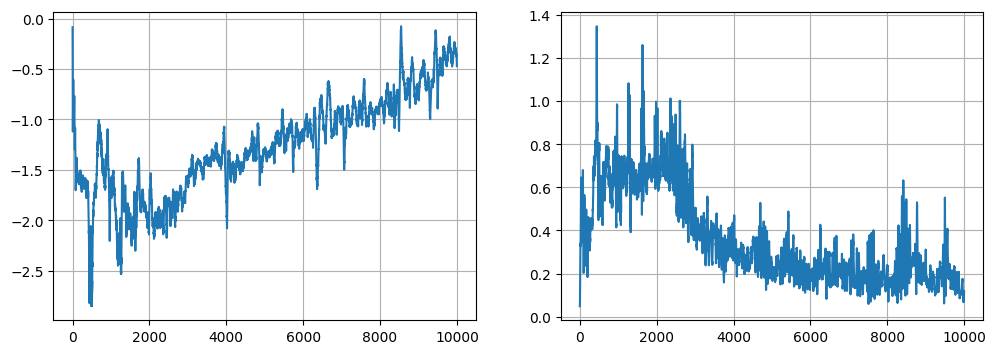

In [20]:
figsize(12,4)
plt.subplot(121)
plt.plot(loss_plot)
plt.grid()
plt.subplot(122)
plt.plot(gradV_plot)
# plt.ylim(0.0, 5.0)
plt.grid()

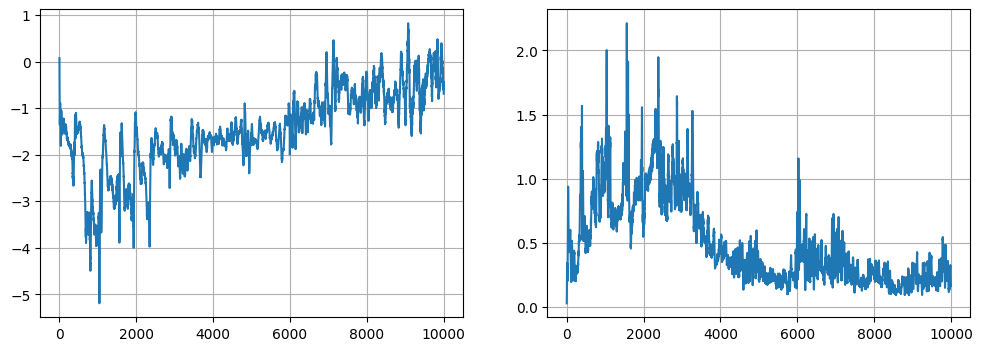

In [ ]:
figsize(12,4)
plt.subplot(121)
plt.plot(loss_plot)
plt.grid()
plt.subplot(122)
plt.plot(gradV_plot)
# plt.ylim(0.0, 5.0)
plt.grid()

In [21]:
dt = 1e-2
t = 0.0
n = int(1/dt)
x = np.zeros((DS,n+1,2))
x[:,0,:] = DATA_0
x_t = np.zeros((DS,n+1,2))
x_t[:,0,:] = DATA_0
t = np.zeros((DS,n+1,1))
key, iter_key = random.split(key)
for i in trange(n):
  x[:,i+1,:] = x[:,i,:] + dt*dsdx_fn(t[:,i,:], x[:,i,:], state_s.params)
  t[:,i+1,:] = t[:,i,:] + dt
  x_t[:,i+1,:] = state_q.apply_fn(state_q.params, t[:,i,:], DATA_0, DATA_1, random.uniform(random.fold_in(iter_key, i), shape=(DS,10)))

100%|██████████| 100/100 [00:04<00:00, 23.60it/s]


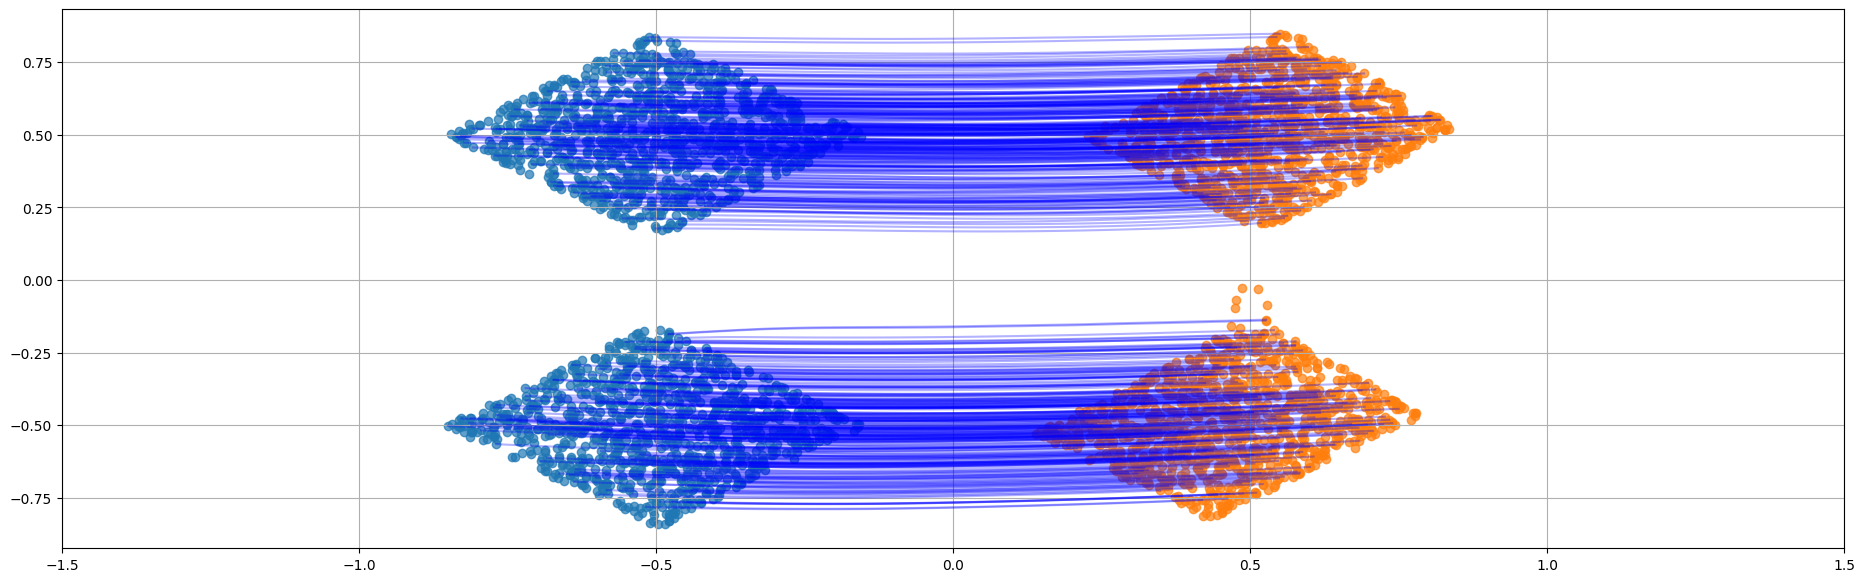

In [22]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], alpha=0.7)
for i in range(BS):
  plt.plot(x[i,:,0], x[i,:,1], c='b', alpha=0.3)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()

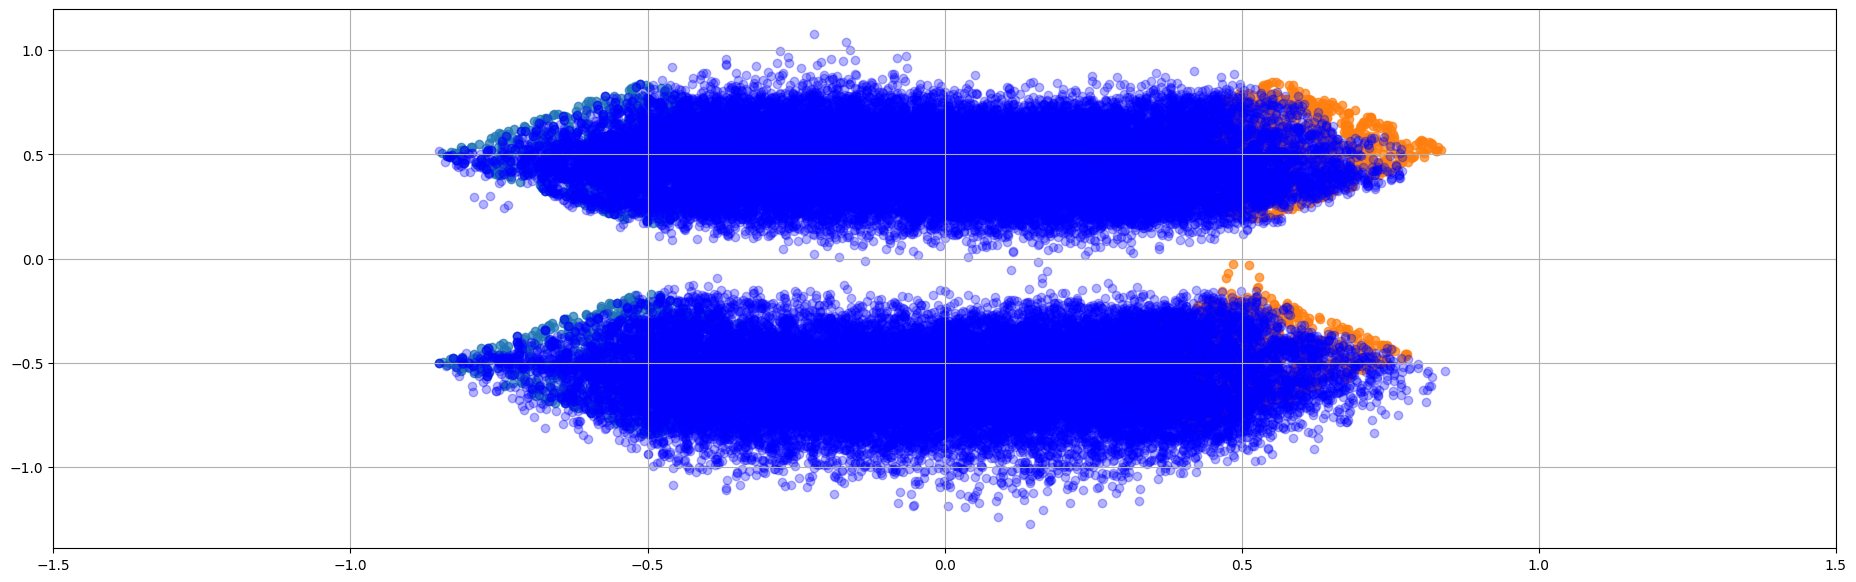

In [23]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], alpha=0.7)
for i in range(BS):
  plt.scatter(x_t[i,:,0], x_t[i,:,1], c='b', alpha=0.3)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()

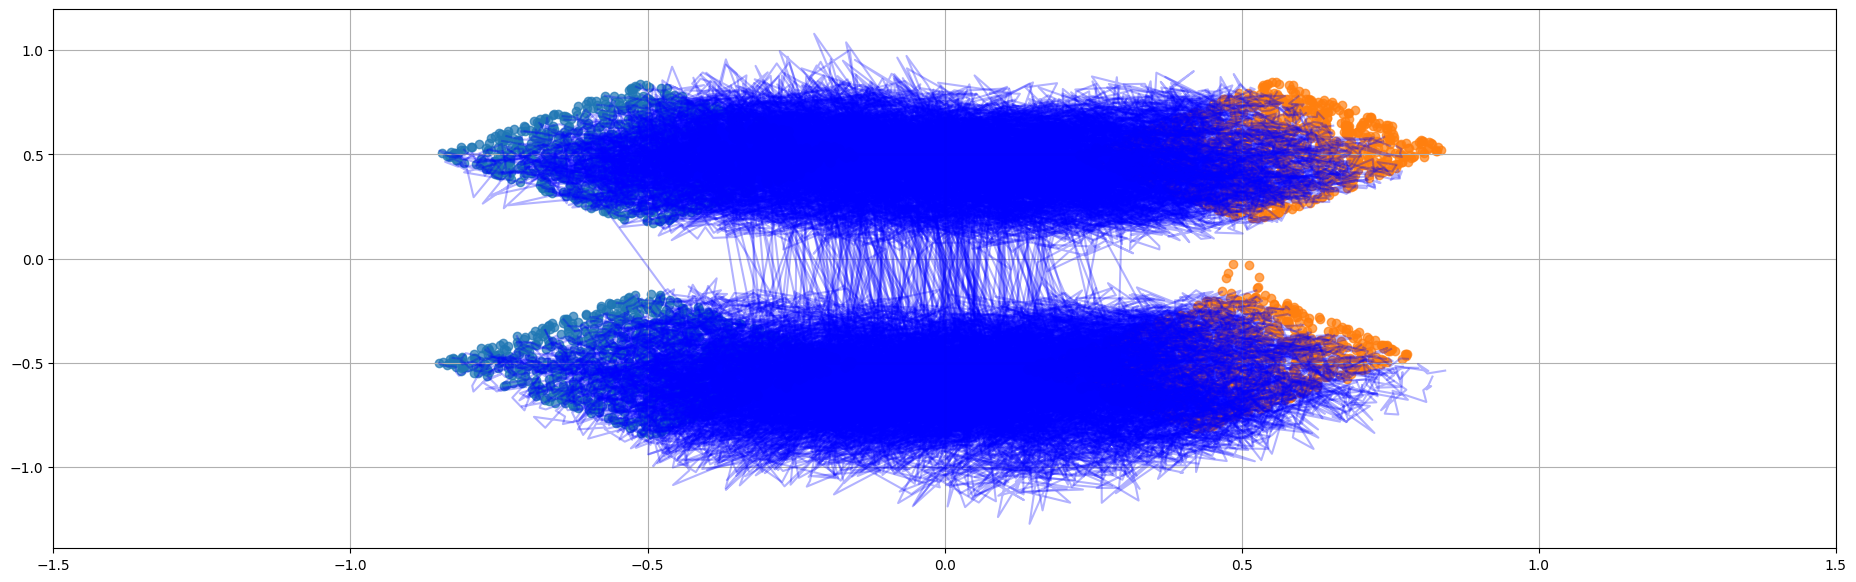

In [24]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], alpha=0.7)
for i in range(BS):
  plt.plot(x_t[i,:,0], x_t[i,:,1], c='b', alpha=0.3)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()

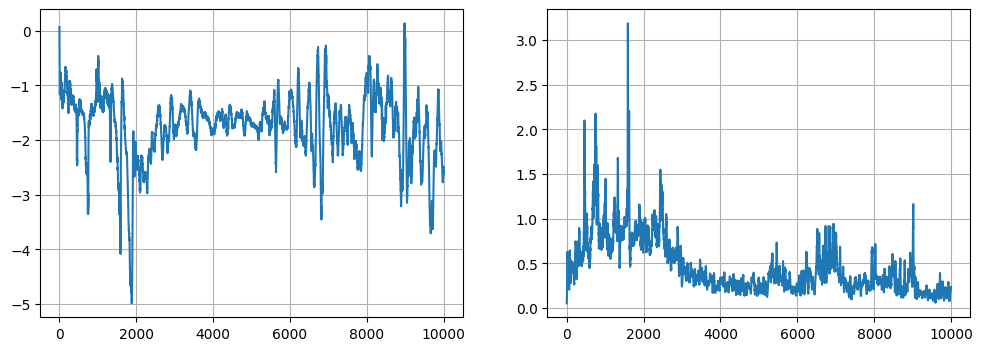

In [97]:
figsize(12,4)
plt.subplot(121)
plt.plot(loss_plot)
plt.grid()
plt.subplot(122)
plt.plot(gradV_plot)
# plt.ylim(0.0, 5.0)
plt.grid()

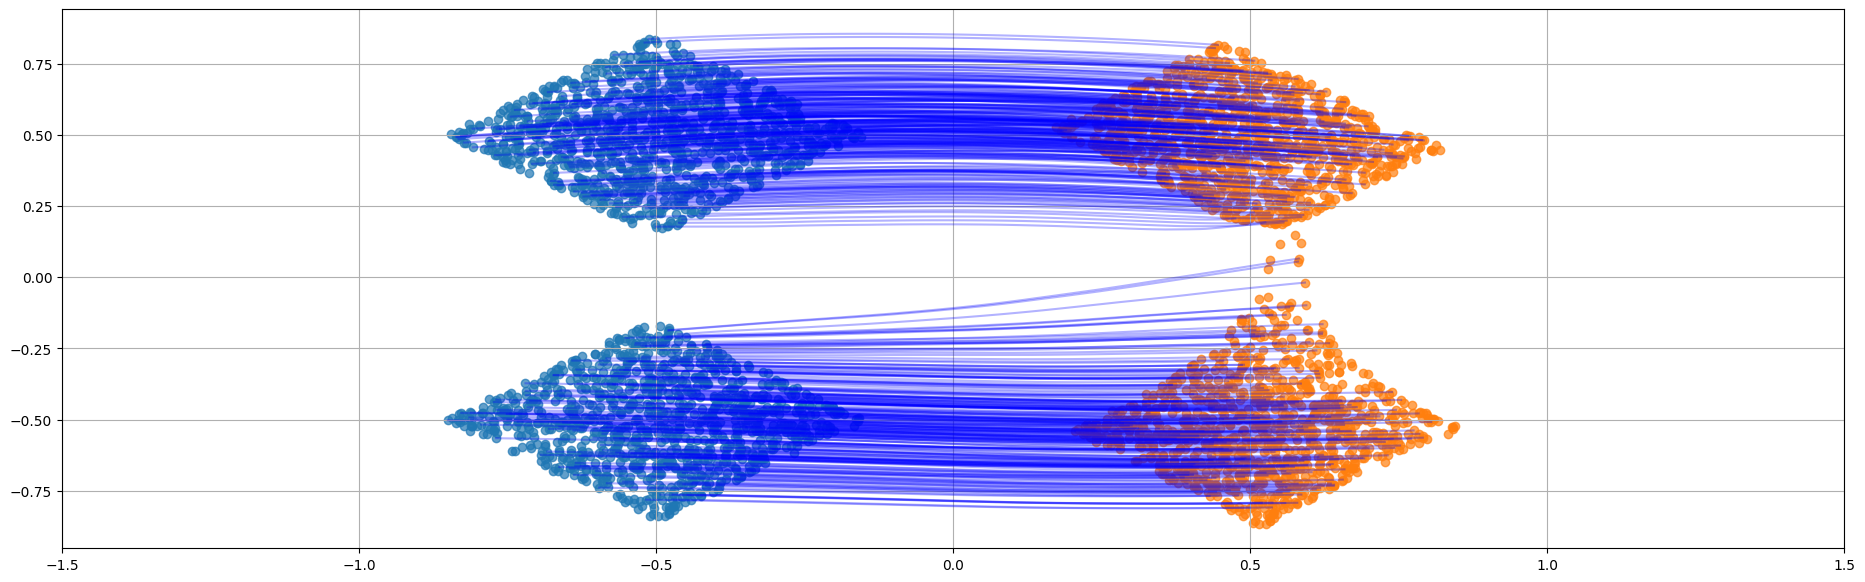

In [98]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], alpha=0.7)
for i in range(BS):
  plt.plot(x[i,:,0], x[i,:,1], c='b', alpha=0.3)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()

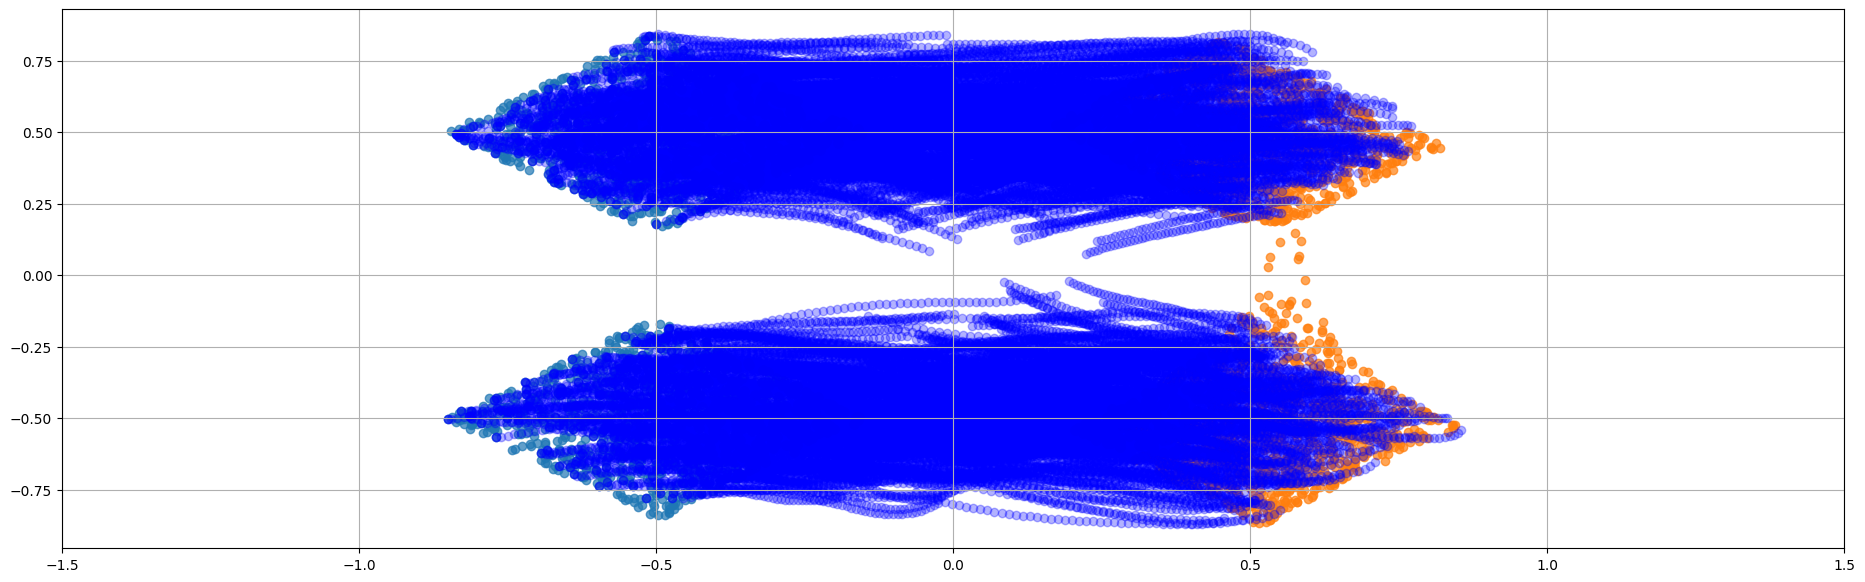

In [99]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], alpha=0.7)
for i in range(BS):
  plt.scatter(x_t[i,:,0], x_t[i,:,1], c='b', alpha=0.3)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()

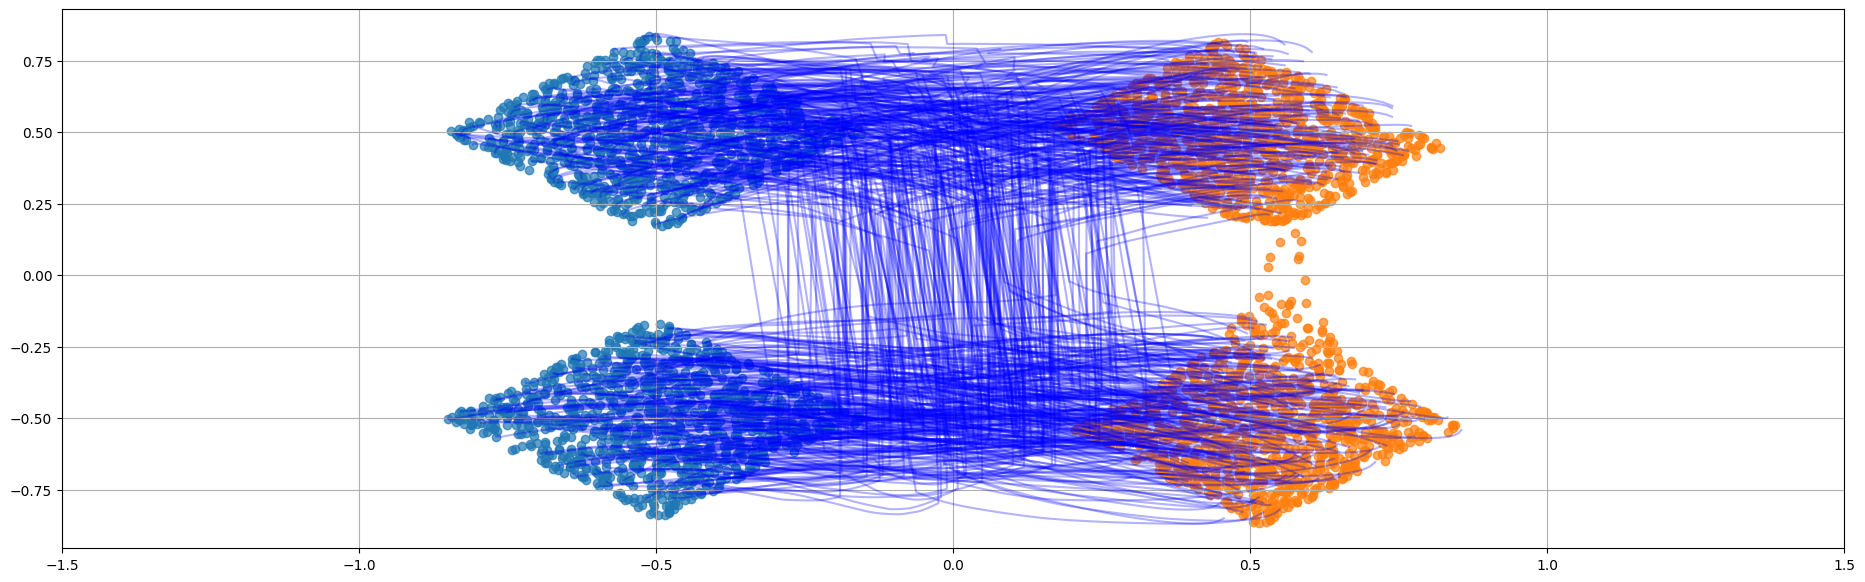

In [100]:
figsize(23,7)
plt.scatter(DATA_0[:,0], DATA_0[:,1], alpha=0.7)
plt.scatter(x[:,-1,0], x[:,-1,1], alpha=0.7)
for i in range(BS):
  plt.plot(x_t[i,:,0], x_t[i,:,1], c='b', alpha=0.3)
plt.xlim(-1.5,1.5)
plt.grid()
plt.show()